### Imports


In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import contextily as cx
from pysal.lib import cg as geometry
from pysal.lib import weights
import numpy as np
import itertools
from shapely.ops import unary_union
import seaborn


from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output


/home/abdullah/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_3532/3533101643.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeo

## Preprocessing and Cleaning of Dataset


### Preprocessing the USA Counties Dataset

- The dataset includes many columns but I'm only concerned with a few of them. I will keep the column I want and drop the rest of them.
- I will only be keeping the data of the counties for which I have Illness data for, and I will drop the rest of them.


In [2]:
usa_counties = gp.read_file("./Datasets/USA_Counties/USA_Counties.shp")


In [3]:
usa_counties.tail()


,NAME,STATE_NAME,POP2010,POP10_SQMI,POP2012,POP12_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS07,AVG_SIZE07,CROP_ACR07,AVG_SALE07,SQMI,geometry
3216,Vega Baja,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,46.52,"MULTIPOLYGON (((-7389092.135 2095082.949, -738..."
3217,Vieques,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,51.00,"POLYGON ((-7287931.984 2048045.066, -7287936.3..."
3218,Villalba,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,36.98,"POLYGON ((-7398679.094 2058408.740, -7398662.7..."
3219,Yabucoa,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,55.03,"MULTIPOLYGON (((-7324309.318 2045566.508, -732..."
3220,Yauco,Puerto Rico,-99,-99.0,-99,-99.0,-99,-99,-99,-99,...,-99,-99,-99,-99,-99.0,-99.0,-99.0,-99.0,68.81,"POLYGON ((-7439169.322 2057526.561, -7439076.2..."


#### Dropping Unnecessary Columns


In [4]:
usa_counties = usa_counties[["NAME", "STATE_NAME", "geometry"]]
usa_counties["REGION"] = "None"
usa_counties.tail()


,NAME,STATE_NAME,geometry,REGION
3216,Vega Baja,Puerto Rico,"MULTIPOLYGON (((-7389092.135 2095082.949, -738...",None
3217,Vieques,Puerto Rico,"POLYGON ((-7287931.984 2048045.066, -7287936.3...",None
3218,Villalba,Puerto Rico,"POLYGON ((-7398679.094 2058408.740, -7398662.7...",None
3219,Yabucoa,Puerto Rico,"MULTIPOLYGON (((-7324309.318 2045566.508, -732...",None
3220,Yauco,Puerto Rico,"POLYGON ((-7439169.322 2057526.561, -7439076.2...",None


#### Labler Function & Counties Lists


In [5]:
def labler(usa_counties, counties_names, region_name):
    usa_counties.loc[
        usa_counties.isin(counties_names).any(axis=1), "REGION"
    ] = region_name
    return usa_counties


# Bay Area
bay_area_counties = [
    "Alameda",
    "Contra Costa",
    "Marin",
    "Napa",
    "San Francisco",
    "San Mateo",
    "Santa Clara",
    "Santa Cruz",
    "Solano",
    "Sonoma",
]
# Central Valley
cnetral_counties = [
    "Calaveras",
    "Fresno",
    "Inyo",
    "Kings",
    "Madera",
    "Mariposa",
    "Merced",
    "Mono",
    "Monterey",
    "San Benito",
    "San Joaquin",
    "Stanislaus",
    "Tulare",
    "Tuolumne",
]
# Northen
northern_counties = [
    "Alpine",
    "Amador",
    "Butte",
    "Colusa",
    "Del Norte",
    "El Dorado",
    "Glenn",
    "Humboldt",
    "Lake",
    "Lassen",
    "Mendocino",
    "Modoc",
    "Nevada",
    "Placer",
    "Plumas",
    "Sacramento",
    "Shasta",
    "Sierra",
    "Siskiyou",
    "Sutter",
    "Tehama",
    "Trinity",
    "Yolo",
    "Yuba",
]
# Upper Southern
upper_southern_counties = [
    "Kern",
    "Los Angeles",
    "San Luis Obispo",
    "Santa Barbara",
    "Ventura",
]
# Lower Southern
lower_southern_counties = [
    "Imperial",
    "Orange",
    "Riverside",
    "San Bernardino",
    "San Diego",
]


#### Labelling Counties


In [6]:
# Labeling Bay Area Counties
usa_counties = labler(usa_counties, bay_area_counties, "Bay Area")
# Labeling Central Valley Counties
usa_counties = labler(usa_counties, cnetral_counties, "Central")
# Labeling Northern Counties
usa_counties = labler(usa_counties, northern_counties, "Northern")
# Labeling Upper Southern Counties
usa_counties = labler(usa_counties, upper_southern_counties, "Upper Southern")
# Labeling Lower Southern Counties
usa_counties = labler(usa_counties, lower_southern_counties, "Lower Southern")


In [7]:
usa_counties = usa_counties.loc[usa_counties["REGION"] != "None"]
usa_counties = usa_counties.loc[
    (usa_counties["STATE_NAME"] == "Nevada")
    | (usa_counties["STATE_NAME"] == "California")
    | (usa_counties["STATE_NAME"] == "Oregon")
]
usa_counties.reset_index(inplace=True)
usa_counties = usa_counties[["NAME", "STATE_NAME", "REGION", "geometry"]]
usa_counties.head()

,NAME,STATE_NAME,REGION,geometry
0,Kern,California,Upper Southern,"POLYGON ((-13119789.473 4272899.442, -13119065..."
1,Kings,California,Central,"POLYGON ((-13342775.428 4356085.351, -13342981..."
2,Lake,California,Northern,"MULTIPOLYGON (((-13667224.315 4696180.987, -13..."
3,Lassen,California,Northern,"POLYGON ((-13418482.359 5039533.376, -13418329..."
4,Los Angeles,California,Upper Southern,"POLYGON ((-13159267.125 3996208.125, -13159278..."


#### Plotting Counties


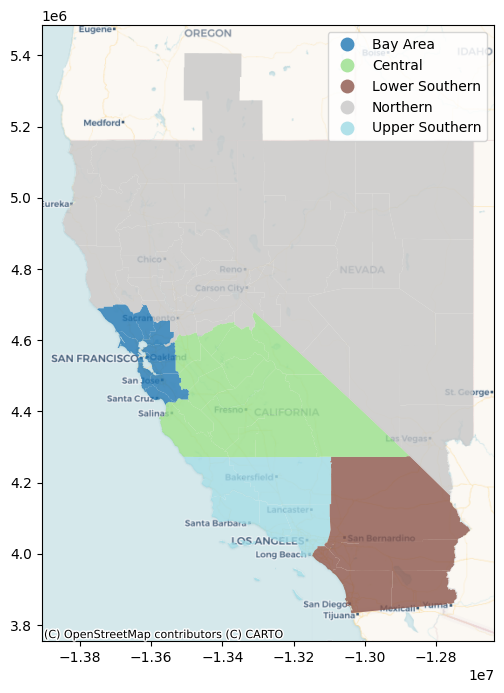

In [8]:
fig, axs = plt.subplots(figsize=(8, 8))
usa_counties.plot(ax=axs, column="REGION", legend=True, cmap="tab20", alpha=0.8)

cx.add_basemap(axs, crs=usa_counties.crs, source=cx.providers.CartoDB.Voyager)


### Preprocessing the AQI Dataset

- The AQI Dataset has day to day values, but I'm going to be needing weekly values of AQI.
- I will aggregate the daily AQI values into weekly values


##### Importing the Dataset


In [9]:
aqi_df_2017 = pd.read_csv(
    "./Datasets/AQI Dataset by County/daily_aqi_by_county_2017.csv"
)
aqi_df_2018 = pd.read_csv(
    "./Datasets/AQI Dataset by County/daily_aqi_by_county_2018.csv"
)
aqi_df_2019 = pd.read_csv(
    "./Datasets/AQI Dataset by County/daily_aqi_by_county_2019.csv"
)
aqi_df_2020 = pd.read_csv(
    "./Datasets/AQI Dataset by County/daily_aqi_by_county_2020.csv"
)


##### Converting the daily data into weekly data

- This data contains the daily data but for my disease data is weekly so I need to convert this data into weekly data as well.
- I'm using the maximum AQI value in a given week.


In [10]:
def daily_to_weekly_processing(aqi_df):
    aqi_df.rename(columns={"county Name": "NAME"}, inplace=True)
    aqi_df.rename(columns={"State Name": "STATE_NAME"}, inplace=True)

    # Dropping unnecessary columns
    aqi_df = aqi_df.loc[aqi_df["NAME"].isin(usa_counties["NAME"])]
    aqi_df = aqi_df[
        ["STATE_NAME", "NAME", "AQI", "Date", "Category", "Defining Parameter"]
    ]

    # Convert Date column to datetime type
    aqi_df["Date"] = pd.to_datetime(aqi_df["Date"])

    # Add a new column called 'date_code' that maps each date to its corresponding week number
    aqi_df["date_code"] = aqi_df["Date"].apply(
        lambda x: (x.strftime("%Y") + "{:02d}".format(x.week))
    )

    # Add a new column called 'Week' that maps each date to its corresponding week number
    aqi_df["Week"] = aqi_df["Date"].dt.week

    # Calculate maximum AQI for each week and save in new column
    aqi_df["max_aqi"] = aqi_df.groupby(["NAME", "Week"])["AQI"].transform(max)

    # Filtering dataframe to keep only rows with maximum AQI value for each week
    aqi_df = aqi_df[aqi_df["AQI"] == aqi_df["max_aqi"]]

    return aqi_df


- Cleaning the date_code values that is removing week duplicates and forward filling any missing values


In [11]:
def removing_duplicates_filling(aqi_df, year):
    aqi_df = aqi_df[
        ["STATE_NAME", "NAME", "AQI", "date_code", "Category", "Defining Parameter"]
    ]
    aqi_df.drop_duplicates()

    # Create a new DataFrame with all weeks of the year
    date_range = pd.date_range(start=year + "-01-01", end=year + "-12-31", freq="W")
    new_df = pd.DataFrame({"date_code": date_range})

    # Split the date_code column into year and week columns
    date_codes = [str(d.year) + str(d.weekofyear).zfill(2) for d in date_range]

    # create a dataframe with all possible combinations of county names and date codes
    counties = aqi_df["NAME"].unique()
    df_index = pd.MultiIndex.from_product(
        [counties, date_codes], names=["NAME", "date_code"]
    )
    new_df = pd.DataFrame(index=df_index).reset_index()

    # merge the original data to fill in missing data and remove duplicates
    new_aqi = new_df.merge(
        aqi_df, on=["NAME", "date_code"], how="left"
    ).drop_duplicates(["NAME", "date_code"])

    # fill missing AQI values with the previous week's value for each county
    new_aqi["WEEKLY_MAX_AQI"] = new_aqi.groupby("NAME")["AQI"].fillna(method="ffill")  # type: ignore

    # # Sort the merged DataFrame by county name and date_code
    new_aqi = new_aqi.sort_values(["NAME", "date_code"])

    # shp = pd.DataFrame(usa_counties["NAME"], columns=["NAME"])
    aqi_df = pd.merge(new_aqi, usa_counties["NAME"], on="NAME", how="left")
    # aqi_county_merge.to_csv("aqi_country_merge.csv")
    return aqi_df


In [12]:
aqi_df_2017 = daily_to_weekly_processing(aqi_df_2017)
aqi_df_2018 = daily_to_weekly_processing(aqi_df_2018)
aqi_df_2019 = daily_to_weekly_processing(aqi_df_2019)
aqi_df_2020 = daily_to_weekly_processing(aqi_df_2020)


In [13]:
aqi_df_2017 = removing_duplicates_filling(aqi_df_2017, "2017")
aqi_df_2018 = removing_duplicates_filling(aqi_df_2018, "2018")
aqi_df_2019 = removing_duplicates_filling(aqi_df_2019, "2019")
aqi_df_2020 = removing_duplicates_filling(aqi_df_2020, "2020")


### Preprocessing the Influenza Cases Count Dataset

- This datasets includes the counts of different types of influenza virus cases in different counties of US
- I will only be keeping the data from 2017 to 2020.
- I also don't need the individual count of influenza virus cases, I will only use the total cases.


In [14]:
illness_df = pd.read_csv(
    "./Datasets/Illness Count Dataset/C_Counts of ILI Diseases by Region.csv"
)


- Only keeping data after 2017


In [15]:
# Convert Date column to datetime type
illness_df["weekending"] = pd.to_datetime(illness_df["weekending"])
illness_df = illness_df.loc[illness_df["weekending"] >= "2017"]
illness_df = illness_df.loc[illness_df["Influenza_Category"] == "Influenza_Total"]
illness_df = illness_df.loc[illness_df["region"] != "California"]

illness_df.rename(columns={"Count": "Influenza Positive Cases"}, inplace=True)
illness_df.rename(columns={"region": "REGION"}, inplace=True)
illness_df


,season,date_code,weekending,REGION,Influenza_Category,Influenza Positive Cases
18320,2016-2017,201701,2017-01-01,Bay Area,Influenza_Total,307
18340,2016-2017,201701,2017-01-01,Central,Influenza_Total,43
18350,2016-2017,201701,2017-01-01,Lower Southern,Influenza_Total,175
18360,2016-2017,201701,2017-01-01,Northern,Influenza_Total,41
18370,2016-2017,201701,2017-01-01,Upper Southern,Influenza_Total,104
...,...,...,...,...,...,...
30020,2019-2020,202040,2020-09-27,Bay Area,Influenza_Total,0
30040,2019-2020,202040,2020-09-27,Central,Influenza_Total,0
30050,2019-2020,202040,2020-09-27,Lower Southern,Influenza_Total,0
30060,2019-2020,202040,2020-09-27,Northern,Influenza_Total,0


- Splitting the Data into 4 years


In [16]:
illness_df_2017 = illness_df.loc[
    (illness_df["weekending"] >= "2017") & (illness_df["weekending"] <= "2017-12-24")
]
illness_df_2018 = illness_df.loc[
    (illness_df["weekending"] > "2017-12-24")
    & (illness_df["weekending"] <= "2018-12-24")
]
illness_df_2019 = illness_df.loc[
    (illness_df["weekending"] >= "2018-12-24")
    & (illness_df["weekending"] <= "2019-12-24")
]
illness_df_2020 = illness_df.loc[(illness_df["weekending"] >= "2019-12-24")]


In [17]:
illness_df_2017 = illness_df_2017[["date_code", "REGION", "Influenza Positive Cases"]]
illness_df_2018 = illness_df_2018[["date_code", "REGION", "Influenza Positive Cases"]]
illness_df_2019 = illness_df_2019[["date_code", "REGION", "Influenza Positive Cases"]]
illness_df_2020 = illness_df_2020[["date_code", "REGION", "Influenza Positive Cases"]]


In [18]:
illness_df_2017


,date_code,REGION,Influenza Positive Cases
18320,201701,Bay Area,307
18340,201701,Central,43
18350,201701,Lower Southern,175
18360,201701,Northern,41
18370,201701,Upper Southern,104
...,...,...,...
21380,201752,Bay Area,160
21400,201752,Central,41
21410,201752,Lower Southern,325
21420,201752,Northern,3


### Combining the Datasets

- Here I will combine all three datasets into a single dataset


- Merging the AQI Dataset with Geometries and Regional Data of Influenza Positive Test Cases


In [19]:
def dataset_merger(data, illness_data):
    # Merging the AQI data with the USA counties geometry data
    data = pd.merge(
        data, usa_counties[["NAME", "geometry", "REGION"]], on="NAME", how="left"
    )
    # Converting the merged data to a GeoDataFrame
    data = gp.GeoDataFrame(data, geometry=data["geometry"])
    # Convert the date_code column to an integer type
    data["date_code"] = data["date_code"].astype("int64")

    # Merging the AQI data with the illness data
    final_data = pd.merge(data, illness_data, on=["date_code", "REGION"], how="right")

    # Reordering the columns
    final_data = final_data.reindex(
        columns=[
            "date_code",
            "NAME",
            "REGION",
            "Influenza Positive Cases",
            "WEEKLY_MAX_AQI",
            "Category",
            "Defining Parameter",
            "STATE_NAME",
            "geometry",
        ]
    )

    return final_data


In [20]:
def column_renamer(data):
    data.rename(
        columns={
            "date_code": "DATE_CODE",
            "Influenza Positive Cases": "INFLUENZA_POSTIVE_CASES",
            "WEEKLY_MAX_AQI": "WEEKLY_MAX_AQI",
            "Category": "CATEGORY",
            "Defining Parameter": "DEFINING_PARAMETER",
            "STATE_NAME": "STATE_NAME",
        },
        inplace=True,
    )
    return data


In [21]:
final_data_2017 = dataset_merger(aqi_df_2017, illness_df_2017)
final_data_2018 = dataset_merger(aqi_df_2018, illness_df_2018)
final_data_2019 = dataset_merger(aqi_df_2019, illness_df_2019)
final_data_2020 = dataset_merger(aqi_df_2020, illness_df_2020)


In [22]:
final_data_2017 = column_renamer(final_data_2017)
final_data_2018 = column_renamer(final_data_2018)
final_data_2019 = column_renamer(final_data_2019)
final_data_2020 = column_renamer(final_data_2020)


In [23]:
final_data_2020.drop(columns=["geometry"]).to_csv("final_data_2020.csv")


In [24]:
final_data_2020.loc[
    (final_data_2020["REGION"] == "Bay Area") & (final_data_2020["DATE_CODE"] == 202001)
]


,DATE_CODE,NAME,REGION,INFLUENZA_POSTIVE_CASES,WEEKLY_MAX_AQI,CATEGORY,DEFINING_PARAMETER,STATE_NAME,geometry
0,202001,Alameda,Bay Area,120,74.0,Moderate,PM2.5,California,"MULTIPOLYGON (((-13608423.594 4548229.562, -13..."
1,202001,Contra Costa,Bay Area,120,64.0,Moderate,PM2.5,California,"MULTIPOLYGON (((-13573493.205 4540676.362, -13..."
2,202001,Marin,Bay Area,120,59.0,Moderate,PM2.5,California,"POLYGON ((-13682945.969 4589138.750, -13682958..."
3,202001,Napa,Bay Area,120,60.0,Moderate,PM2.5,California,"POLYGON ((-13620149.865 4698245.425, -13619936..."
4,202001,San Francisco,Bay Area,120,60.0,Moderate,PM2.5,California,"MULTIPOLYGON (((-13692698.013 4536182.208, -13..."
5,202001,San Mateo,Bay Area,120,48.0,Good,PM2.5,California,"MULTIPOLYGON (((-13618773.843 4454508.553, -13..."
6,202001,Santa Clara,Bay Area,120,62.0,Moderate,PM2.5,California,"POLYGON ((-13593215.125 4502827.781, -13593226..."
7,202001,Santa Cruz,Bay Area,120,165.0,Unhealthy,PM2.5,Arizona,"POLYGON ((-13605624.004 4469113.195, -13605620..."
8,202001,Solano,Bay Area,120,79.0,Moderate,PM2.5,California,"POLYGON ((-13568166.784 4655864.858, -13568148..."
9,202001,Sonoma,Bay Area,120,57.0,Moderate,PM2.5,California,"POLYGON ((-13667271.875 4696163.000, -13667259..."


## Analysis, Plotting, Corelations


### Filling Missing Data Based on Kernel Weights

- The Dataset does not have AQI values for all the counties of California but I do have their geometries
- I will calculate the neighbors of the missing counties (ones with no AQI data) and I will assign them AQI values based on their neighbors.
- I am calculating the neighbors using Kernel Weights


In [25]:
def week_rows(year):
    weeks = [
        str(y) + str(w).zfill(2)
        for y, w in itertools.product([year], range(1, (53 if year != 2020 else 41)))
    ]
    states = [
        "Lassen",
        "Modoc",
        "Sierra",
        "Alpine",
        "Yuba",
        "Esmeralda",
        "Eureka",
        "Lander",
        "Mineral",
        "Pershing",
        "Storey",
    ]
    regions = ["Northern"]

    new_data = pd.DataFrame(
        list(itertools.product(states, weeks, regions)),
        columns=["NAME", "DATE_CODE", "REGION"],
    )
    return new_data


def get_extra_county_df():
    final_data_states = final_data_2017["NAME"].unique()
    county_geometries_list = usa_counties["NAME"].unique()

    extra_counties = {"NAME": [], "geometry": [], "REGION": []}
    extra_counties_list = []

    for county in county_geometries_list:
        if county not in final_data_states:
            extra_counties_list.append(county)
            extra_counties["NAME"].append(county)
            extra_counties["geometry"].append(
                usa_counties.loc[usa_counties["NAME"] == county]["geometry"].values[0]
            )
            extra_counties["REGION"].append(
                usa_counties.loc[usa_counties["NAME"] == county]["REGION"].values[0]
            )

    return gp.GeoDataFrame(extra_counties, geometry=extra_counties["geometry"])


def add_missing_counties(final_data, year):
    _ex_df = get_extra_county_df().merge(
        week_rows(year), on=["NAME", "REGION"], how="right"
    )

    _ex_df["DATE_CODE"] = _ex_df["DATE_CODE"].astype("int64")

    final_data = pd.concat([final_data, _ex_df], ignore_index=True)
    final_data.sort_values(by="DATE_CODE", inplace=True)

    return final_data

In [26]:
new_final_data_2017 = add_missing_counties(final_data_2017, 2017)
new_final_data_2018 = add_missing_counties(final_data_2018, 2018)
new_final_data_2019 = add_missing_counties(final_data_2019, 2019)
new_final_data_2020 = add_missing_counties(final_data_2020, 2020)


In [27]:
final_data_states = final_data_2017["NAME"].unique()
county_geometries_list = usa_counties["NAME"].unique()

extra_counties = {"NAME": [], "geometry": [], "REGION": []}
extra_counties_list = []

for county in county_geometries_list:
    if county not in final_data_states:
        extra_counties_list.append(county)
        extra_counties["NAME"].append(county)
        extra_counties["geometry"].append(
            usa_counties.loc[usa_counties["NAME"] == county]["geometry"].values[0]
        )
        extra_counties["REGION"].append(
            usa_counties.loc[usa_counties["NAME"] == county]["REGION"].values[0]
        )

In [28]:
extra_counties_df = usa_counties.loc[usa_counties["NAME"].isin(extra_counties_list)]
extra_counties_df


,NAME,STATE_NAME,REGION,geometry
3,Lassen,California,Northern,"POLYGON ((-13418482.359 5039533.376, -13418329..."
10,Modoc,California,Northern,"POLYGON ((-13502305.915 5160605.154, -13501922..."
31,Sierra,California,Northern,"POLYGON ((-13454256.340 4832637.658, -13454127..."
35,Alpine,California,Northern,"POLYGON ((-13347105.179 4711608.303, -13345787..."
54,Yuba,California,Northern,"POLYGON ((-13471845.369 4805888.527, -13471912..."
62,Esmeralda,Nevada,Northern,"MULTIPOLYGON (((-13042803.140 4514011.171, -13..."
63,Eureka,Nevada,Northern,"POLYGON ((-12975454.169 5012388.579, -12975356..."
65,Lander,Nevada,Northern,"POLYGON ((-13001416.880 5012387.100, -13000263..."
68,Mineral,Nevada,Northern,"POLYGON ((-13132001.995 4732245.303, -13129975..."
70,Pershing,Nevada,Northern,"POLYGON ((-13233610.424 5006598.988, -13233216..."


- Plotting the Extra Counties for which I don't have AQI data


<Axes: >

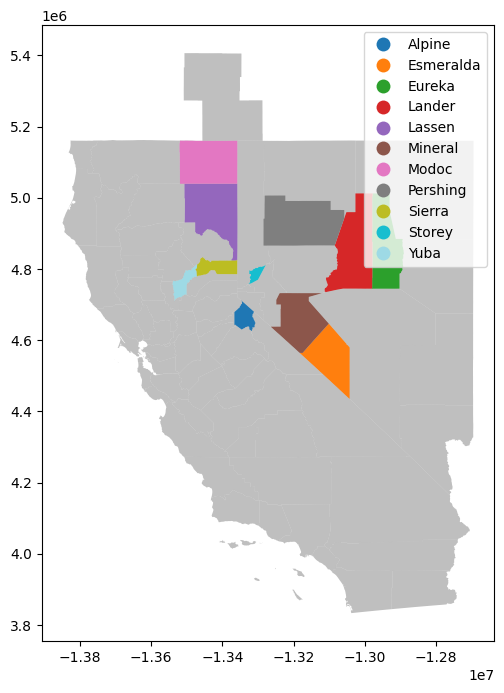

In [29]:
fig, axs = plt.subplots(figsize=(8, 8))
usa_counties.plot(ax=axs, column="NAME", color="grey", alpha=0.5)
extra_counties_df.plot(ax=axs, column="NAME", cmap="tab20", legend=True)


##### Calculating the Nearest Counties in the Extra Counties DF

- Here, I will find the nearest counties (from usa_counties_df) to each of the county in the extra_counties_df.
- For that, I will use Adaptive Kernel Weights


In [30]:
# Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(usa_counties, fixed=False, k=6)
# Print first five bandwidth values
w_adaptive.bandwidth[:5]


array([[186490.74915148],
       [158749.65337817],
       [111729.73505142],
       [184676.06686892],
       [239324.70687016]])

In [31]:
extra_counties_neighbors = {}

for county in extra_counties_df["NAME"]:
    neighbors_list = []
    county_row = usa_counties.loc[usa_counties["NAME"] == county]

    # Don't add the county itself to the neighbors list
    for neighbor in w_adaptive.neighbors[county_row.index.values[0]]:
        neighbors_list.append(
            usa_counties.loc[neighbor]["NAME"]
        ) if neighbor != county_row.index.values[0] else None

    extra_counties_neighbors[county] = neighbors_list

In [32]:
extra_counties_neighbors


{'Lassen': ['Plumas', 'Washoe', 'Modoc', 'Sierra', 'Shasta', 'Butte'],
 'Modoc': ['Lassen', 'Washoe', 'Lake', 'Shasta', 'Siskiyou', 'Plumas'],
 'Sierra': ['Nevada', 'Plumas', 'Placer', 'Yuba', 'Carson City', 'Storey'],
 'Alpine': ['Douglas',
  'Carson City',
  'Tuolumne',
  'El Dorado',
  'Lyon',
  'Amador'],
 'Yuba': ['Sutter', 'Butte', 'Nevada', 'Placer', 'Colusa', 'Sierra'],
 'Esmeralda': ['Nye', 'Mineral', 'Mono', 'Inyo', 'Lyon', 'Madera'],
 'Eureka': ['Lander', 'White Pine', 'Elko', 'Churchill', 'Pershing', 'Nye'],
 'Lander': ['Eureka',
  'Churchill',
  'Pershing',
  'Humboldt',
  'White Pine',
  'Mineral'],
 'Mineral': ['Mono', 'Lyon', 'Esmeralda', 'Douglas', 'Churchill', 'Alpine'],
 'Pershing': ['Churchill', 'Washoe', 'Humboldt', 'Lander', 'Storey', 'Lyon'],
 'Storey': ['Carson City', 'Lyon', 'Douglas', 'Sierra', 'Alpine', 'Churchill']}

- Plotting all the extra counties with no AQI data and their neighbors


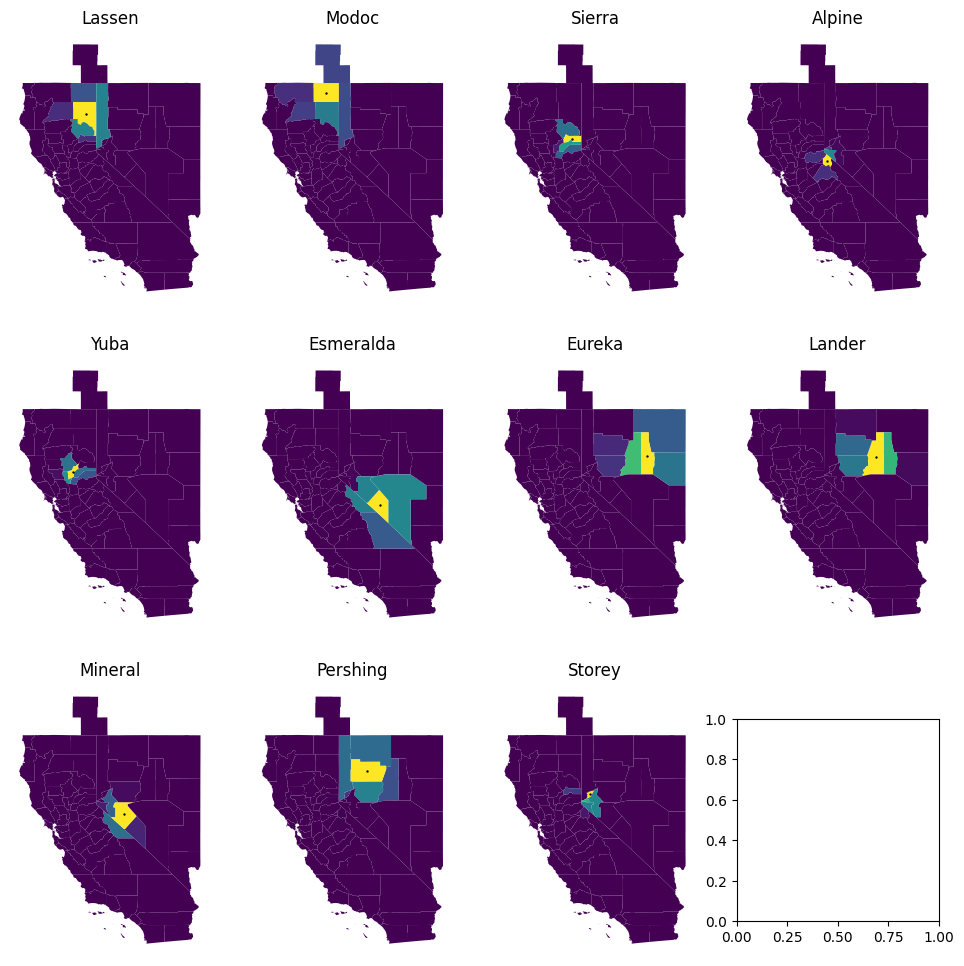

In [33]:
full_matrix, ids = w_adaptive.full()

f, axs = plt.subplots(3, 4, figsize=(12, 12), subplot_kw=dict(aspect="equal"))

for county, axs in zip(extra_counties_df.index, axs.flatten()):
    # Append weights for first polygon and plot on first subplot
    usa_counties.assign(weight_0=full_matrix[county]).plot(
        "weight_0", cmap="viridis", ax=axs
    )

    # Add centroid of focal tracts
    usa_counties.iloc[[county], :].centroid.plot(
        ax=axs, marker=".", markersize=2, color="k", label="Focal Tract"
    )
    axs.set_axis_off()
    # Add titles
    axs.set_title(usa_counties.iloc[[county], :]["NAME"].values[0])


- Assinging WEEKLY_AQI values based on the AQI values of nearest neighbors


In [34]:
def assign_missing_weekly_aqi_data(final_data):
    # Iterating Through Every Week
    for week in final_data["DATE_CODE"].unique():
        # Iterating Through Every County in the Extra Counties List
        for extra_county in extra_counties_neighbors:
            weekly_max_aqi_list = []

            # Iterating through every neighbor of the extra county
            for neighbor in extra_counties_neighbors[extra_county]:
                # Getting the AQI value for that week and neighbor
                aqi_val = final_data.loc[
                    (final_data["NAME"] == neighbor) & (final_data["DATE_CODE"] == week)
                ]["WEEKLY_MAX_AQI"].values[0]
                # Appending to a list
                weekly_max_aqi_list.append(int(aqi_val) if aqi_val >= 0 else 0)

            # Assiging the Weekly AQI value by taking the mean of aqi values of the neighbors
            np_weekly_max_aqi_list = np.array(weekly_max_aqi_list)
            final_data.loc[
                (final_data["NAME"] == extra_county)
                & (final_data["DATE_CODE"] == week),
                "WEEKLY_MAX_AQI",
            ] = int(np_weekly_max_aqi_list.mean())

    return final_data

In [35]:
new_final_data_2017 = assign_missing_weekly_aqi_data(new_final_data_2017)
new_final_data_2018 = assign_missing_weekly_aqi_data(new_final_data_2018)
new_final_data_2019 = assign_missing_weekly_aqi_data(new_final_data_2019)
new_final_data_2020 = assign_missing_weekly_aqi_data(new_final_data_2020)


- Recombining the Data with Illness Data


In [36]:
def remerging_with_illness_data(final_data, illness_data):
    illness_data.rename(
        columns={
            "date_code": "DATE_CODE",
            "Influenza Positive Cases": "INFLUENZA_POSTIVE_CASES",
        },
        inplace=True,
    )
    final_data = final_data.merge(illness_data, on=["DATE_CODE", "REGION"], how="right")

    final_data.drop(columns=["INFLUENZA_POSTIVE_CASES_x"], inplace=True)
    final_data.rename(
        columns={"INFLUENZA_POSTIVE_CASES_y": "INFLUENZA_POSTIVE_CASES"}, inplace=True
    )

    final_data = final_data.reindex(
        columns=[
            "DATE_CODE",
            "NAME",
            "REGION",
            "INFLUENZA_POSTIVE_CASES",
            "WEEKLY_MAX_AQI",
            "Category",
            "Defining Parameter",
            "STATE_NAME",
            "geometry",
        ]
    )
    final_data = final_data.drop(
        columns=["Category", "Defining Parameter", "STATE_NAME"]
    )
    return final_data


In [37]:
new_final_data_2017 = remerging_with_illness_data(new_final_data_2017, illness_df_2017)
new_final_data_2018 = remerging_with_illness_data(new_final_data_2018, illness_df_2018)
new_final_data_2019 = remerging_with_illness_data(new_final_data_2019, illness_df_2019)
new_final_data_2020 = remerging_with_illness_data(new_final_data_2020, illness_df_2020)


In [38]:
new_final_data_2017.loc[
    (new_final_data_2017["NAME"].isin(extra_counties_neighbors))
    & (new_final_data_2017["DATE_CODE"] == 201702)
]


,DATE_CODE,NAME,REGION,INFLUENZA_POSTIVE_CASES,WEEKLY_MAX_AQI,geometry
125,201702,Eureka,Northern,39,17.0,"POLYGON ((-12975454.169 5012388.579, -12975356..."
126,201702,Storey,Northern,39,47.0,"POLYGON ((-13278591.398 4811103.323, -13278832..."
127,201702,Pershing,Northern,39,36.0,"POLYGON ((-13233610.424 5006598.988, -13233216..."
128,201702,Mineral,Northern,39,51.0,"POLYGON ((-13132001.995 4732245.303, -13129975..."
129,201702,Lander,Northern,39,25.0,"POLYGON ((-13001416.880 5012387.100, -13000263..."
131,201702,Esmeralda,Northern,39,43.0,"MULTIPOLYGON (((-13042803.140 4514011.171, -13..."
132,201702,Yuba,Northern,39,59.0,"POLYGON ((-13471845.369 4805888.527, -13471912..."
133,201702,Sierra,Northern,39,37.0,"POLYGON ((-13454256.340 4832637.658, -13454127..."
134,201702,Lassen,Northern,39,39.0,"POLYGON ((-13418482.359 5039533.376, -13418329..."
135,201702,Modoc,Northern,39,56.0,"POLYGON ((-13502305.915 5160605.154, -13501922..."


### Analyzing the AQI data county wise


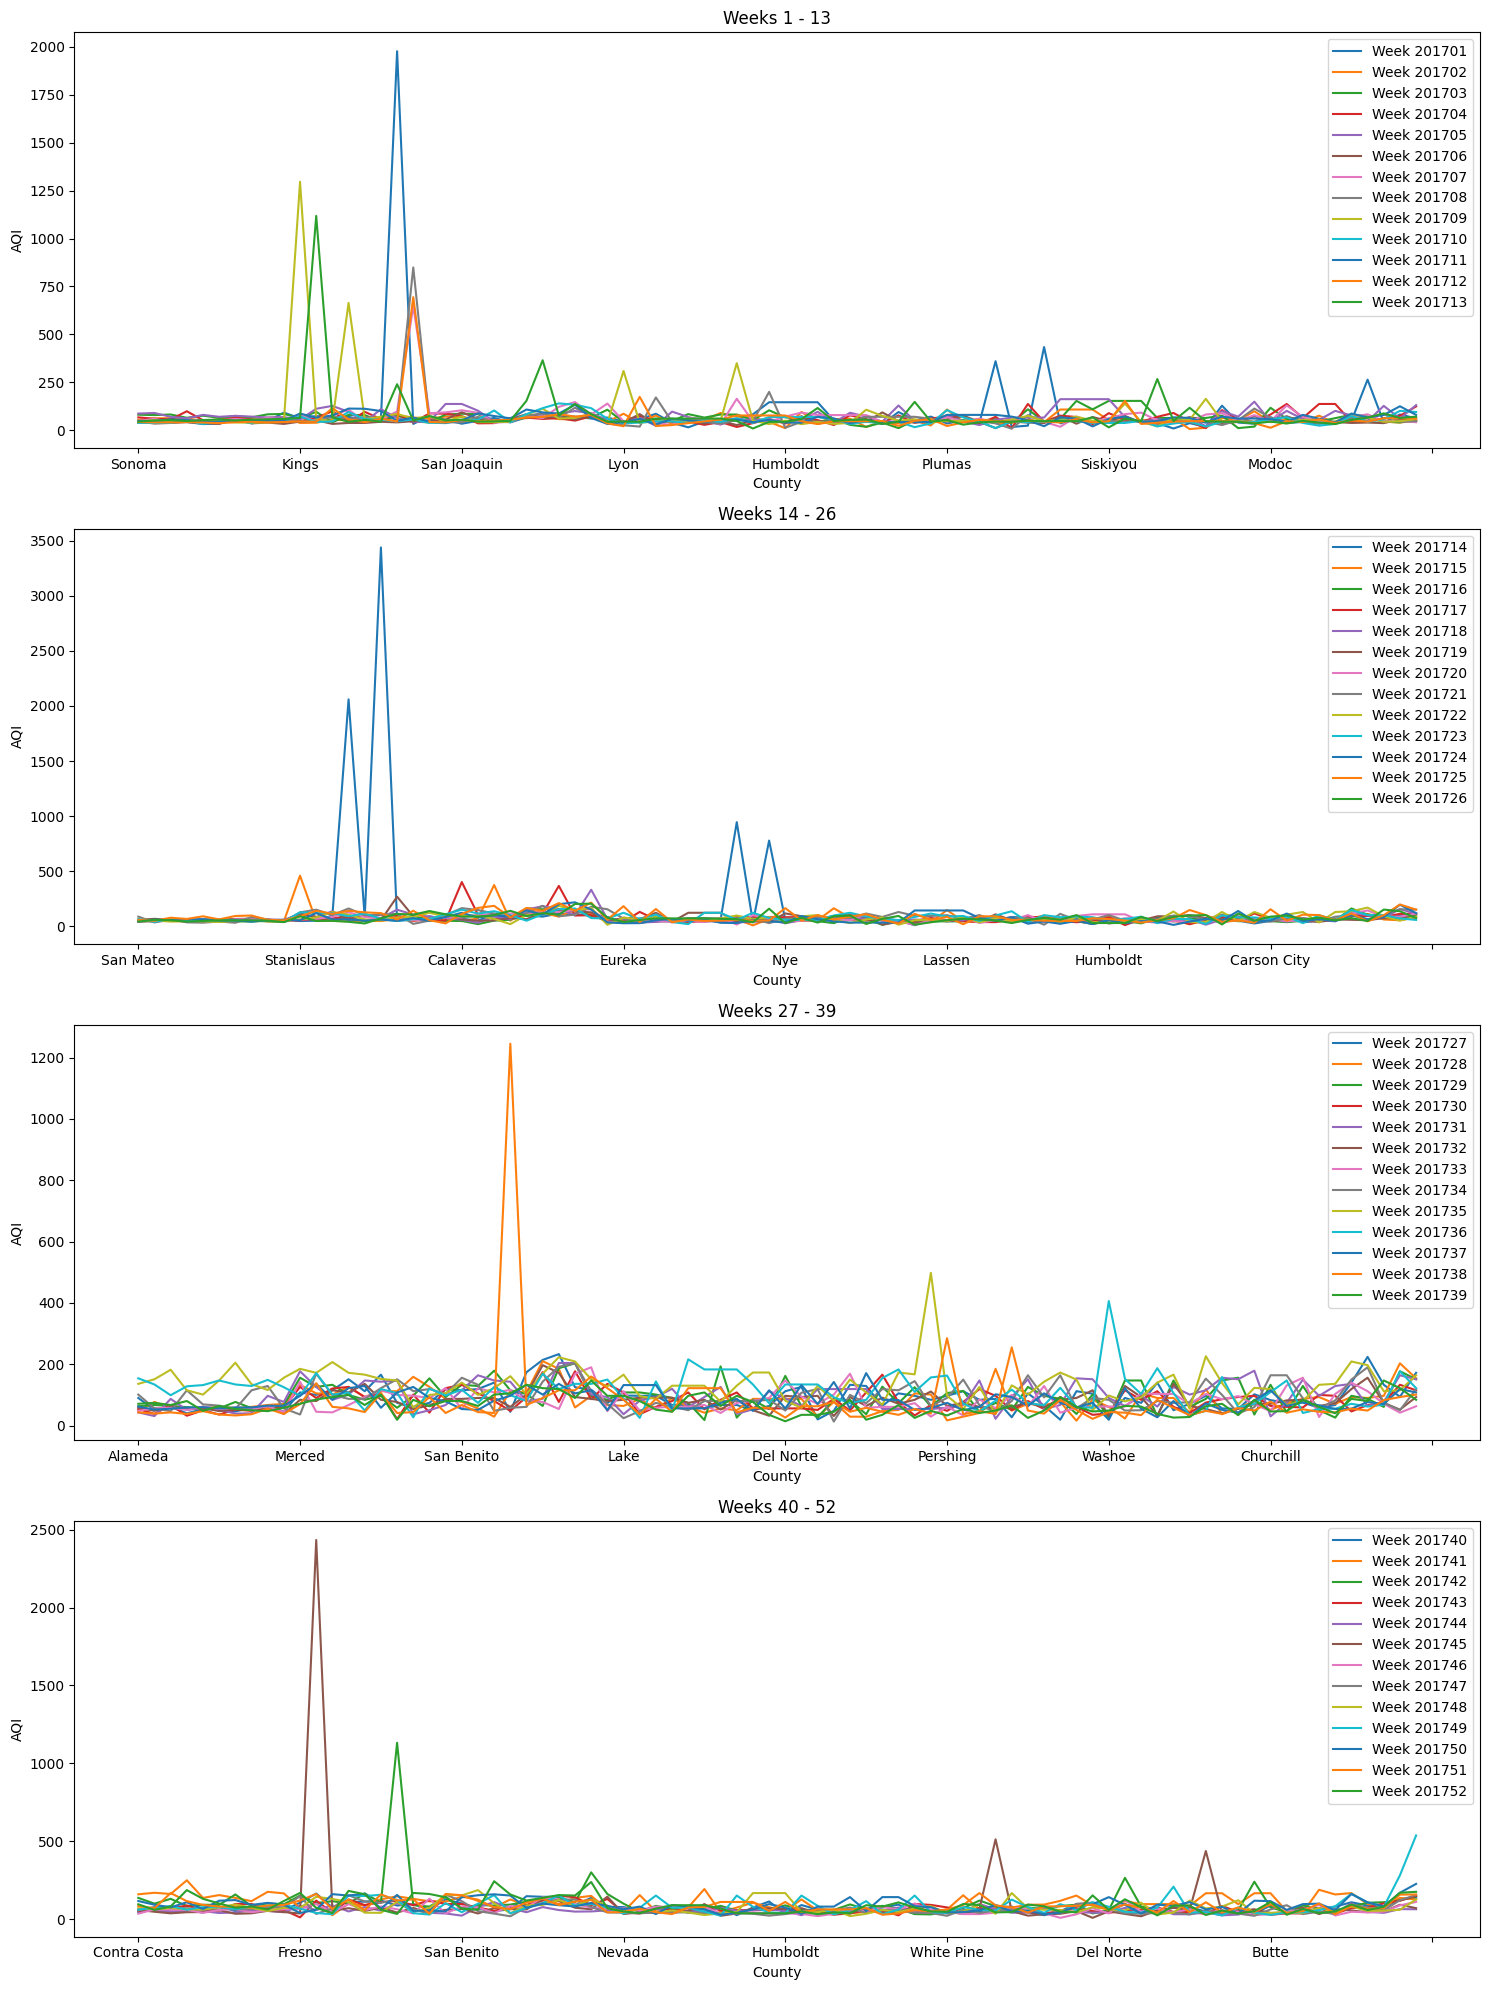

In [39]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
week_count = new_final_data_2017["DATE_CODE"].nunique()
weeks_per_subplot = 13
for i in range(4):
    start_week = i * weeks_per_subplot
    end_week = min(start_week + weeks_per_subplot, week_count)
    weeks = new_final_data_2017["DATE_CODE"].unique()[start_week:end_week]
    for week in weeks:
        week_row = new_final_data_2017.loc[new_final_data_2017["DATE_CODE"] == week]
        week_row.plot.line(
            x="NAME", y="WEEKLY_MAX_AQI", ax=axs[i], label=f"Week {week}"
        )
    axs[i].set_title(f"Weeks {start_week+1} - {end_week}")
    axs[i].set_xlabel("County")
    axs[i].set_ylabel("AQI")
    axs[i].legend()
plt.tight_layout()
plt.show()

- Filtering Data with very High AQI values


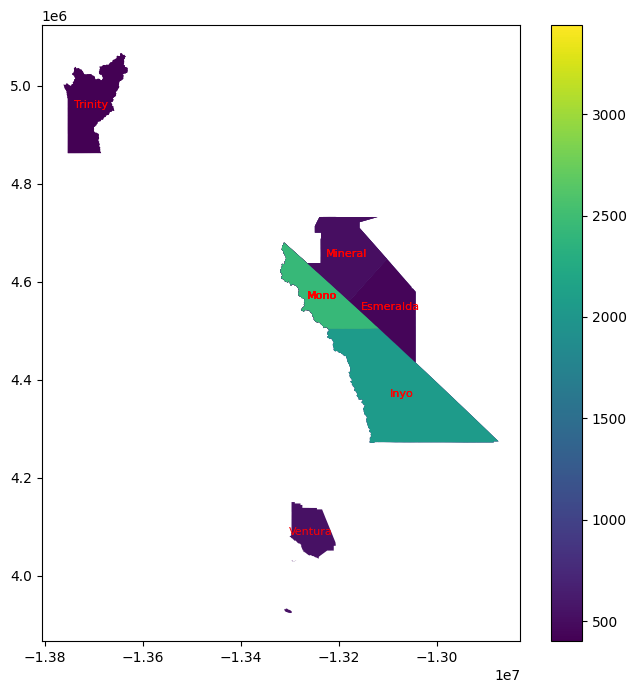

In [40]:
f, axs = plt.subplots(figsize=(8, 8))

week_2017 = new_final_data_2017.loc[new_final_data_2017["WEEKLY_MAX_AQI"] >= 400]
week_2017.plot(column="WEEKLY_MAX_AQI", cmap="viridis", legend=True, ax=axs)

# add county names as annotations to the plot
for idx, row in week_2017.iterrows():
    axs.annotate(
        row["NAME"],
        xy=row.geometry.centroid.coords[0],
        ha="center",
        va="center",
        color="red",
        fontsize=8,
    )


In [ ]:
f, ax = plt.subplots(2, 2, figsize=(12, 8))
week_2017 = new_final_data_2017.loc[new_final_data_2017["WEEKLY_MAX_AQI"] >= 400]
week_2018 = new_final_data_2018.loc[new_final_data_2018["WEEKLY_MAX_AQI"] >= 400]
week_2019 = new_final_data_2019.loc[new_final_data_2019["WEEKLY_MAX_AQI"] >= 400]
week_2020 = new_final_data_2020.loc[new_final_data_2020["WEEKLY_MAX_AQI"] >= 400]

week_2017.plot(column="NAME", cmap="viridis", ax=ax[0][0])
week_2017.plot(
    column="WEEKLY_MAX_AQI",
    cmap="viridis",
    legend=True,
    ax=ax[0][0],
    linewidth=1,
    edgecolor="black",
)
for idx, row in week_2017.iterrows():
    ax[0][0].annotate(
        row["NAME"],
        xy=row.geometry.centroid.coords[0],
        ha="center",
        va="center",
        color="orange",
        fontsize=8,
    )
cx.add_basemap(
    ax[0][0], crs=week_2017.crs.to_string(), source=cx.providers.CartoDB.Voyager
)
ax[0][0].set_title("2017 Counties with Highest AQI Values")
ax[0][0].set_axis_off()

week_2018.plot(column="NAME", cmap="viridis", ax=ax[0][1])
week_2018.plot(
    column="WEEKLY_MAX_AQI",
    cmap="viridis",
    legend=True,
    ax=ax[0][1],
    linewidth=1,
    edgecolor="black",
)
for idx, row in week_2018.iterrows():
    ax[0][1].annotate(
        row["NAME"],
        xy=row.geometry.centroid.coords[0],
        ha="center",
        va="center",
        color="orange",
        fontsize=8,
    )
cx.add_basemap(
    ax[0][1], crs=week_2018.crs.to_string(), source=cx.providers.CartoDB.Voyager
)
ax[0][1].set_title("2018 Counties with Highest AQI Values")
ax[0][1].set_axis_off()

week_2019.plot(column="NAME", cmap="viridis", ax=ax[1][0])
week_2019.plot(
    column="WEEKLY_MAX_AQI",
    cmap="viridis",
    legend=True,
    ax=ax[1][0],
    linewidth=1,
    edgecolor="black",
)
for idx, row in week_2019.iterrows():
    ax[1][0].annotate(
        row["NAME"],
        xy=row.geometry.centroid.coords[0],
        ha="center",
        va="center",
        color="orange",
        fontsize=8,
    )
cx.add_basemap(
    ax[1][0], crs=week_2019.crs.to_string(), source=cx.providers.CartoDB.Voyager
)
ax[1][0].set_title("2019 Counties with Highest AQI Values")
ax[1][0].set_axis_off()


week_2020.plot(column="NAME", cmap="viridis", ax=ax[1][1])
week_2020.plot(
    column="WEEKLY_MAX_AQI",
    cmap="viridis",
    legend=True,
    ax=ax[1][1],
    linewidth=1,
    edgecolor="black",
)
for idx, row in week_2020.iterrows():
    ax[1][1].annotate(
        row["NAME"],
        xy=row.geometry.centroid.coords[0],
        ha="center",
        va="center",
        color="orange",
        fontsize=8,
    )
cx.add_basemap(
    ax[1][1], crs=week_2020.crs.to_string(), source=cx.providers.CartoDB.Voyager
)
ax[1][1].set_title("2020 Counties with Highest AQI Values")
ax[1][1].set_axis_off()


##### County with consistent High AQI Values


,DATE_CODE,NAME,REGION,INFLUENZA_POSTIVE_CASES,WEEKLY_MAX_AQI,geometry
16,201701,Mono,Central,43,1977.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
497,201707,Mono,Central,26,647.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
577,201708,Mono,Central,17,849.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
650,201709,Mono,Central,21,1296.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
897,201712,Mono,Central,10,694.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
1055,201714,Mono,Central,1,3439.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
1130,201715,Mono,Central,0,459.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
1300,201717,Mono,Central,1,401.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
2983,201738,Mono,Central,0,1245.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
3296,201742,Mono,Central,0,1132.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."


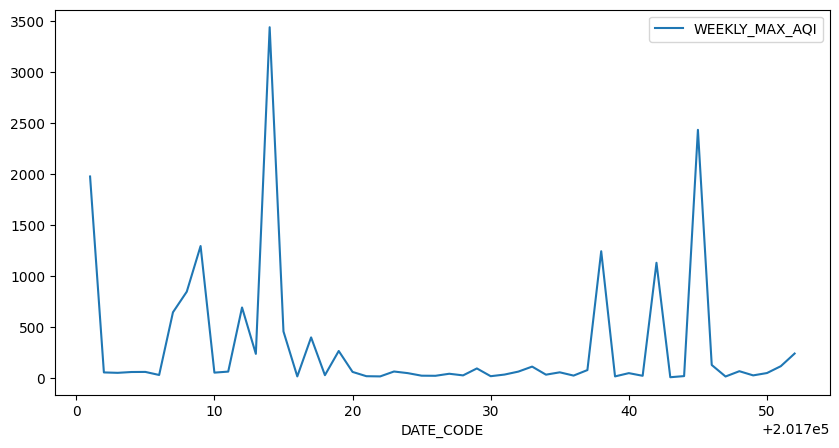

In [ ]:
mono_df = new_final_data_2017.loc[new_final_data_2017["NAME"] == "Mono"]
mono_df.plot.line(x="DATE_CODE", y="WEEKLY_MAX_AQI", figsize=(10, 5))
mono_df = mono_df.loc[mono_df["WEEKLY_MAX_AQI"] >= 400]
mono_df

,DATE_CODE,NAME,REGION,INFLUENZA_POSTIVE_CASES,WEEKLY_MAX_AQI,geometry
650,201909,Mono,Central,26,3323.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
976,201913,Mono,Central,37,515.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
1381,201918,Mono,Central,8,1611.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
1538,201920,Mono,Central,4,3852.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
2983,201938,Mono,Central,0,1763.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."
3056,201939,Mono,Central,0,2206.0,"POLYGON ((-13305023.419 4674333.605, -13304221..."


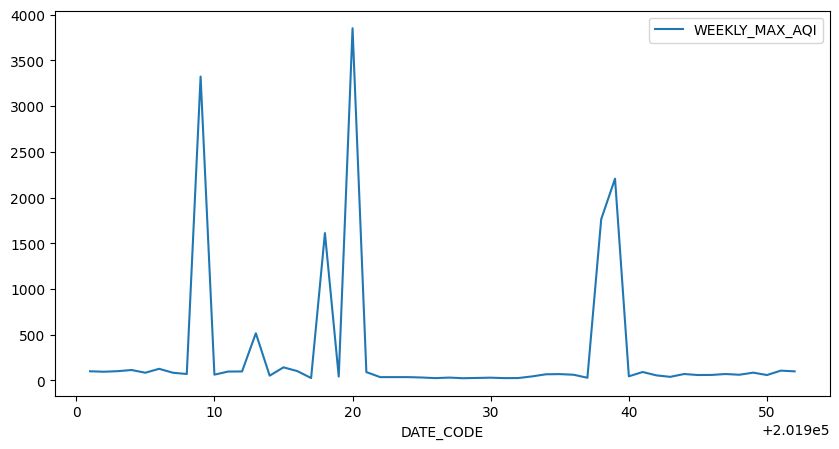

In [ ]:
mono_df = new_final_data_2019.loc[new_final_data_2019["NAME"] == "Mono"]
mono_df.plot.line(x="DATE_CODE", y="WEEKLY_MAX_AQI", figsize=(10, 5))
mono_df = mono_df.loc[mono_df["WEEKLY_MAX_AQI"] >= 400]
mono_df

- Finding the week with the highest average WEEKLY_AQI values


<Axes: >

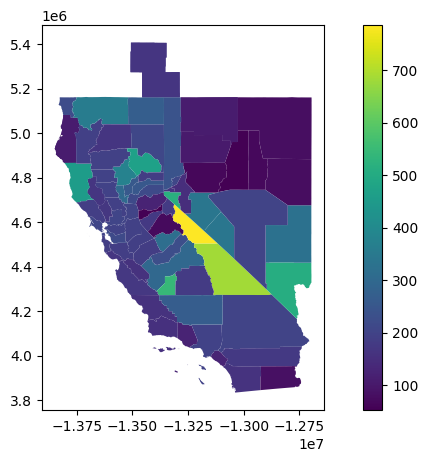

In [ ]:
highest_aqi_week_id = (
    new_final_data_2020.groupby("DATE_CODE")["WEEKLY_MAX_AQI"].mean().idxmax()
)
highest_aqi_week = new_final_data_2020.loc[
    new_final_data_2020["DATE_CODE"] == highest_aqi_week_id
]
highest_aqi_week.plot(
    column="WEEKLY_MAX_AQI", cmap="viridis", legend=True, figsize=(10, 5)
)


### Spatial Autocorrelation on the Week with Highest Weekly AQI Values


#### Finding the week with maximum Spatial Autocorelation


In [67]:
def get_weights(df, k):
    w = weights.KNN.from_dataframe(df, k=k)
    w.transform = "R"
    return w


def get_corelation(week):
    return esda.moran.Moran(week["WEEKLY_MAX_AQI"], get_weights(week, 4)).I


In [ ]:
def get_yearly_corelations(df, yearly_corelations):
    corelation_list = []

    for week in df["DATE_CODE"].unique():
        week_row = df.loc[df["DATE_CODE"] == week]

        yearly_corelations[week] = get_corelation(week_row)

    return yearly_corelations


In [ ]:
yearly_corelations = {}
yearly_corelations = get_yearly_corelations(new_final_data_2017, yearly_corelations)
yearly_corelations = get_yearly_corelations(new_final_data_2018, yearly_corelations)
yearly_corelations = get_yearly_corelations(new_final_data_2019, yearly_corelations)
yearly_corelations = get_yearly_corelations(new_final_data_2020, yearly_corelations)


In [ ]:
max_corelation_date_code = max(yearly_corelations, key=yearly_corelations.get)
print(max_corelation_date_code, yearly_corelations[max_corelation_date_code])


201940 0.7659502934757269


In [ ]:
co_df = new_final_data_2019.loc[
    new_final_data_2019["DATE_CODE"] == max_corelation_date_code
]

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(co_df, k=4)
# Row-standardization
w.transform = "R"

co_df["WEEKLY_MAX_AQI_LAG"] = weights.spatial_lag.lag_spatial(
    w, co_df["WEEKLY_MAX_AQI"]
)


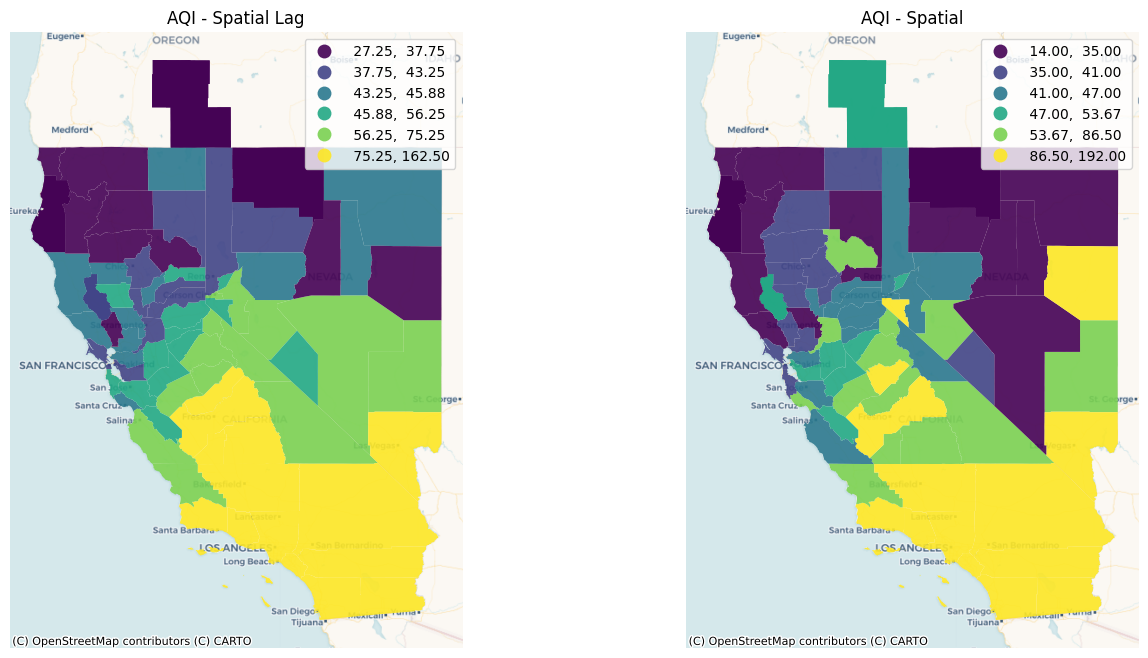

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axs

co_df.plot(
    column="WEEKLY_MAX_AQI_LAG",
    cmap="viridis",
    scheme="quantiles",
    k=6,
    edgecolor="white",
    linewidth=0.0,
    legend=True,
    ax=ax1,
    alpha=0.9,
)
cx.add_basemap(ax=ax1, crs=co_df.crs.to_string(), source=cx.providers.CartoDB.Voyager)
ax1.set_axis_off()
ax1.set_title("AQI - Spatial Lag")

co_df.plot(
    column="WEEKLY_MAX_AQI",
    cmap="viridis",
    scheme="quantiles",
    k=6,
    edgecolor="white",
    linewidth=0.0,
    legend=True,
    ax=ax2,
    alpha=0.9,
)
cx.add_basemap(ax=ax2, crs=co_df.crs.to_string(), source=cx.providers.CartoDB.Voyager)
ax2.set_axis_off()
ax2.set_title("AQI - Spatial")

plt.show()

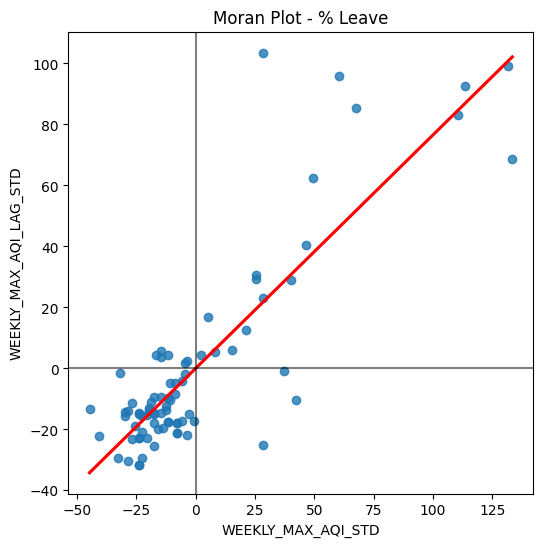

In [ ]:
co_df["WEEKLY_MAX_AQI_STD"] = co_df["WEEKLY_MAX_AQI"] - co_df["WEEKLY_MAX_AQI"].mean()
co_df["WEEKLY_MAX_AQI_LAG_STD"] = (
    co_df["WEEKLY_MAX_AQI_LAG"] - co_df["WEEKLY_MAX_AQI_LAG"].mean()
)


f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="WEEKLY_MAX_AQI_STD",
    y="WEEKLY_MAX_AQI_LAG_STD",
    ci=None,
    data=co_df,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - % Leave")
plt.show()


### Plotting the WEEKLY AQI Data County Wise


In [ ]:
combined_df_aqi = pd.concat(
    [new_final_data_2017, new_final_data_2018, new_final_data_2019, new_final_data_2020]
)

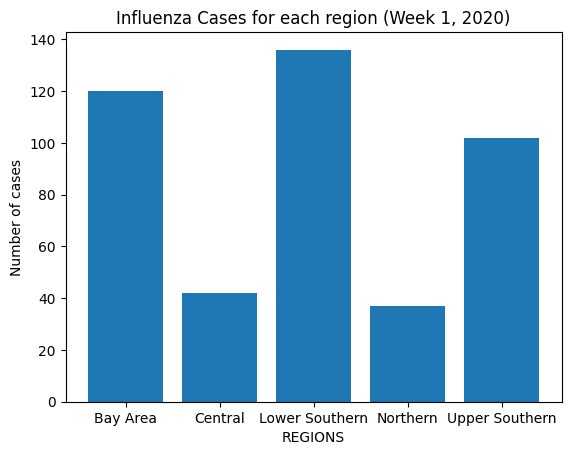

In [ ]:
week = combined_df_aqi.loc[combined_df_aqi["DATE_CODE"] == 202001]
region_counts = week.groupby("REGION")["INFLUENZA_POSTIVE_CASES"].mean()
plt.bar(region_counts.index, region_counts.values)
plt.xlabel("REGIONS")
plt.ylabel("Number of cases")
plt.title("Influenza Cases for each region (Week 1, 2020)")
plt.show()

In [ ]:
week_slider = widgets.IntSlider(
    min=combined_df_aqi["DATE_CODE"].min(),
    max=combined_df_aqi["DATE_CODE"].max(),
    step=1,
    value=combined_df_aqi["DATE_CODE"].min(),
    description="Week",
)
week_slider.layout.width = "100%"
week_slider.layout.height = "20px"


def plot_aqi_by_week(week):
    clear_output()

    fig, axs = plt.subplots(figsize=(8, 8))
    week_row = combined_df_aqi.loc[combined_df_aqi["DATE_CODE"] == week]
    week_row.plot(column="WEEKLY_MAX_AQI", cmap="Reds", legend=True, ax=axs)
    # plt.xticks(rotation=90)
    plt.xlabel("County")
    plt.ylabel("AQI")
    plt.title("AQI values by county for week {}".format(week))
    axs.set_axis_off()

    display(week_slider)


def on_week_change(change):
    plot_aqi_by_week(change.new)


week_slider.observe(on_week_change, names="value")

display(week_slider)

IntSlider(value=201701, description='Week', layout=Layout(height='20px', width='100%'), max=202040, min=201701…

### Converting Low Res AQI Data to High Res Data

- The AQI Data I currently have is only for individual counties, in order to relate it with the Influenza Data I need to change to Regional Data because I have regional data for influenza cases


In [ ]:
temp = new_final_data_2017.copy(deep=True)


In [ ]:
def county_aqi_to_region_aqi(final_data):
    for region in final_data["REGION"].unique():
        for week in final_data["DATE_CODE"].unique():
            mean_aqi = final_data.loc[
                (final_data["REGION"] == region) & (final_data["DATE_CODE"] == week)
            ]["WEEKLY_MAX_AQI"].mean()
            final_data.loc[
                (final_data["REGION"] == region) & (final_data["DATE_CODE"] == week),
                "REGIONAL_MEAN_AQI",
            ] = int(mean_aqi)

    final_data = final_data.reindex(
        columns=[
            "DATE_CODE",
            "NAME",
            "REGION",
            "REGIONAL_MEAN_AQI",
            "INFLUENZA_POSTIVE_CASES",
            "WEEKLY_MAX_AQI",
            "geometry",
        ]
    )
    return final_data

In [ ]:
new_final_data_2017 = county_aqi_to_region_aqi(new_final_data_2017)
new_final_data_2018 = county_aqi_to_region_aqi(new_final_data_2018)
new_final_data_2019 = county_aqi_to_region_aqi(new_final_data_2019)
new_final_data_2020 = county_aqi_to_region_aqi(new_final_data_2020)

### Plotting the REGIONAL geometries, Maximum AQI Week (Regional) & Maximum Cases Week (Regional)


In [ ]:
df = new_final_data_2019.copy(deep=True)

max_aqi_week = new_final_data_2019.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].max()
max_aqi_week = max_aqi_week.idxmax()

max_cases_week = new_final_data_2019.groupby("DATE_CODE")[
    "INFLUENZA_POSTIVE_CASES"
].sum()
max_cases_week = max_cases_week.idxmax()


Text(0.5, 1.0, 'AQI by Region\nWeek with Highest AQI Values\nWeek Number: 201920')

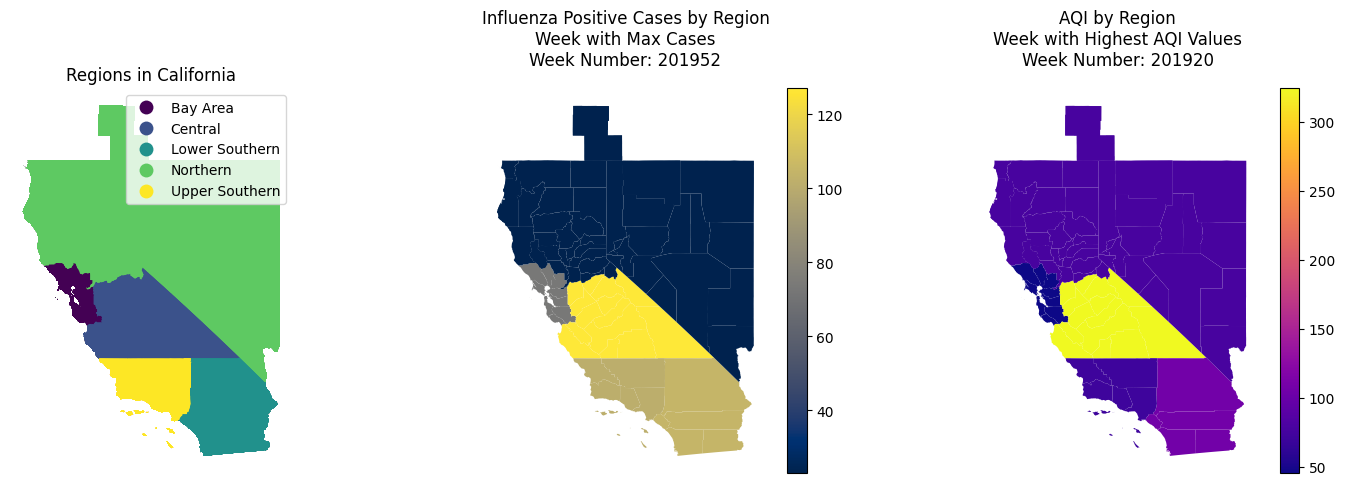

In [ ]:
df = new_final_data_2019.copy(deep=True)

f, ax = plt.subplots(1, 3, figsize=(18, 5))
for _ax in ax.flatten():
    _ax.set_axis_off()

# Regional Geometry
new_final_data_2017.plot(
    column="REGION",
    cmap="viridis",
    legend=True,
    ax=ax[0],
)
ax[0].set_title("Regions in California")


week = df.loc[df["DATE_CODE"] == max_cases_week]

week.plot(
    column="INFLUENZA_POSTIVE_CASES",
    cmap="cividis",
    legend=True,
    ax=ax[1],
)
ax[1].set_title(
    f"Influenza Positive Cases by Region\nWeek with Max Cases\nWeek Number: {max_cases_week}"
)

week = df.loc[df["DATE_CODE"] == max_aqi_week]

week.plot(
    column="REGIONAL_MEAN_AQI",
    cmap="plasma",
    legend=True,
    ax=ax[2],
)
ax[2].set_title(
    f"AQI by Region\nWeek with Highest AQI Values\nWeek Number: {max_aqi_week}"
)

In [ ]:
df = new_final_data_2017.copy(deep=True)

week_slider = widgets.IntSlider(
    min=df["DATE_CODE"].min(),
    max=df["DATE_CODE"].max(),
    step=1,
    value=df["DATE_CODE"].min(),
    description="Week",
)


def plot_aqi_by_week(week):
    clear_output()

    fig, axs = plt.subplots(figsize=(8, 8))
    week_row = df.loc[df["DATE_CODE"] == week]
    week_row.plot(column="REGIONAL_MEAN_AQI", cmap="Reds", legend=True, ax=axs)
    # plt.xticks(rotation=90)
    plt.xlabel("County")
    plt.ylabel("AQI")
    plt.title("AQI values by Region for week {}".format(week))
    axs.set_axis_off()
    for region in week_row["REGION"].unique():
        row = week_row.loc[week_row["REGION"] == region].iloc[0]
        ill_row = week_row.loc[week_row["REGION"] == region][
            "INFLUENZA_POSTIVE_CASES"
        ].iloc[0]
        annotation_text = f"{region}\nCases: {ill_row}"
        centroid = row.geometry.centroid
        axs.annotate(
            annotation_text,
            xy=(centroid.x, centroid.y),
            xytext=(
                centroid.x + 0.1,
                centroid.y - (0.1 if region != "Northern" else -0.5),
            ),
            ha="center",
            va="center",
            color="black",
            fontsize=12,
        )
    display(week_slider)


def on_week_change(change):
    plot_aqi_by_week(change.new)


week_slider.observe(on_week_change, names="value")

display(week_slider)

IntSlider(value=201701, description='Week', max=201752, min=201701)

## Deductions


### Plotting Trend of AQI Values per Region


- Concatinating all datasets


In [44]:
combined_df = pd.concat(
    [new_final_data_2017, new_final_data_2018, new_final_data_2019, new_final_data_2020]
)
combined_df.drop(columns=["geometry"]).to_csv("final_dataset.csv")

In [ ]:
combined_df_northern = combined_df.loc[combined_df["REGION"] == "Northern"]
combined_df_Lsouthern = combined_df.loc[combined_df["REGION"] == "Lower Southern"]
combined_df_Usouthern = combined_df.loc[combined_df["REGION"] == "Upper Souther"]
combined_df_bay = combined_df.loc[combined_df["REGION"] == "Bay Area"]
combined_df_central = combined_df.loc[combined_df["REGION"] == "Central"]


Text(0.5, 1.0, 'AQI Values by Region through 2017-2020')

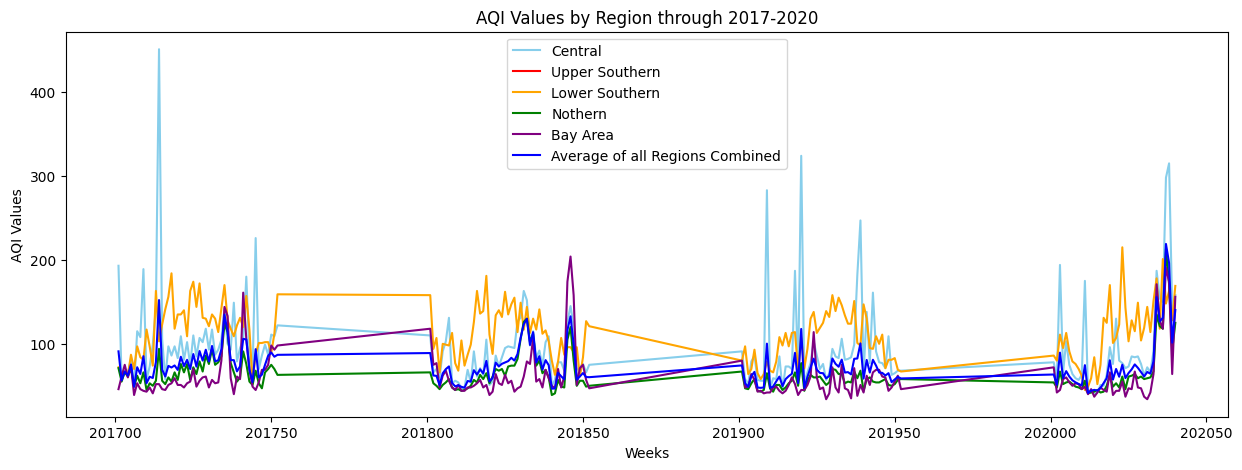

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))

combined_df_central.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Central", color="skyblue", legend=True
)
combined_df_Usouthern.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Upper Southern", color="red", legend=True
)
combined_df_Lsouthern.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Lower Southern", color="orange", legend=True
)
combined_df_northern.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Nothern", color="green", legend=True
)
combined_df_bay.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Bay Area", color="purple", legend=True
)
combined_df.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Average of all Regions Combined", color="blue", legend=True
)
ax.set_xlabel("Weeks")
ax.set_ylabel("AQI Values")
ax.set_title("AQI Values by Region through 2017-2020")

- Trend of Both Influenza Cases and AQI Values


<Axes: xlabel='DATE_CODE'>

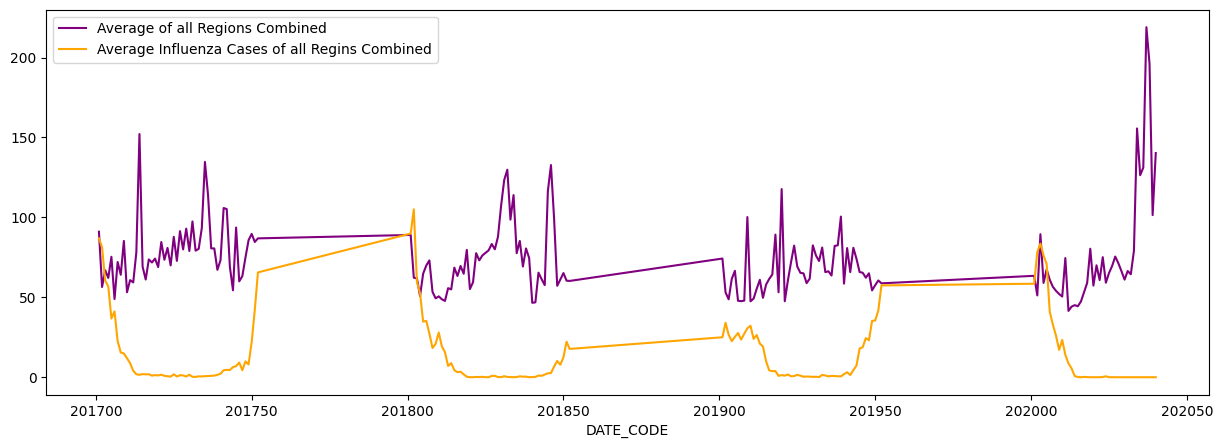

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))

combined_df.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].mean().plot(
    ax=ax, label="Average of all Regions Combined", color="purple", legend=True
)
combined_df.groupby("DATE_CODE")["INFLUENZA_POSTIVE_CASES"].mean().plot(
    ax=ax,
    label="Average Influenza Cases of all Regins Combined",
    color="orange",
    legend=True,
)

- using plotly


In [ ]:
import plotly.express as px

fig = px.line(
    combined_df,
    x="DATE_CODE",
    y="REGIONAL_MEAN_AQI",
    color="REGION",
    labels={
        "DATE_CODE": "Week Number with Year YYYYWW",
        "REGIONAL_MEAN_AQI": "AQI Values",
        "REGION": "Regions",
    },
    title="AQI Values by Region through 2017-2020",
)
fig.show()

In [ ]:
# Dataset to be used for plotting
df_plot = new_final_data_2018.copy(deep=True)


- Plotting Both AQI and Influenza Cases to see any corelation


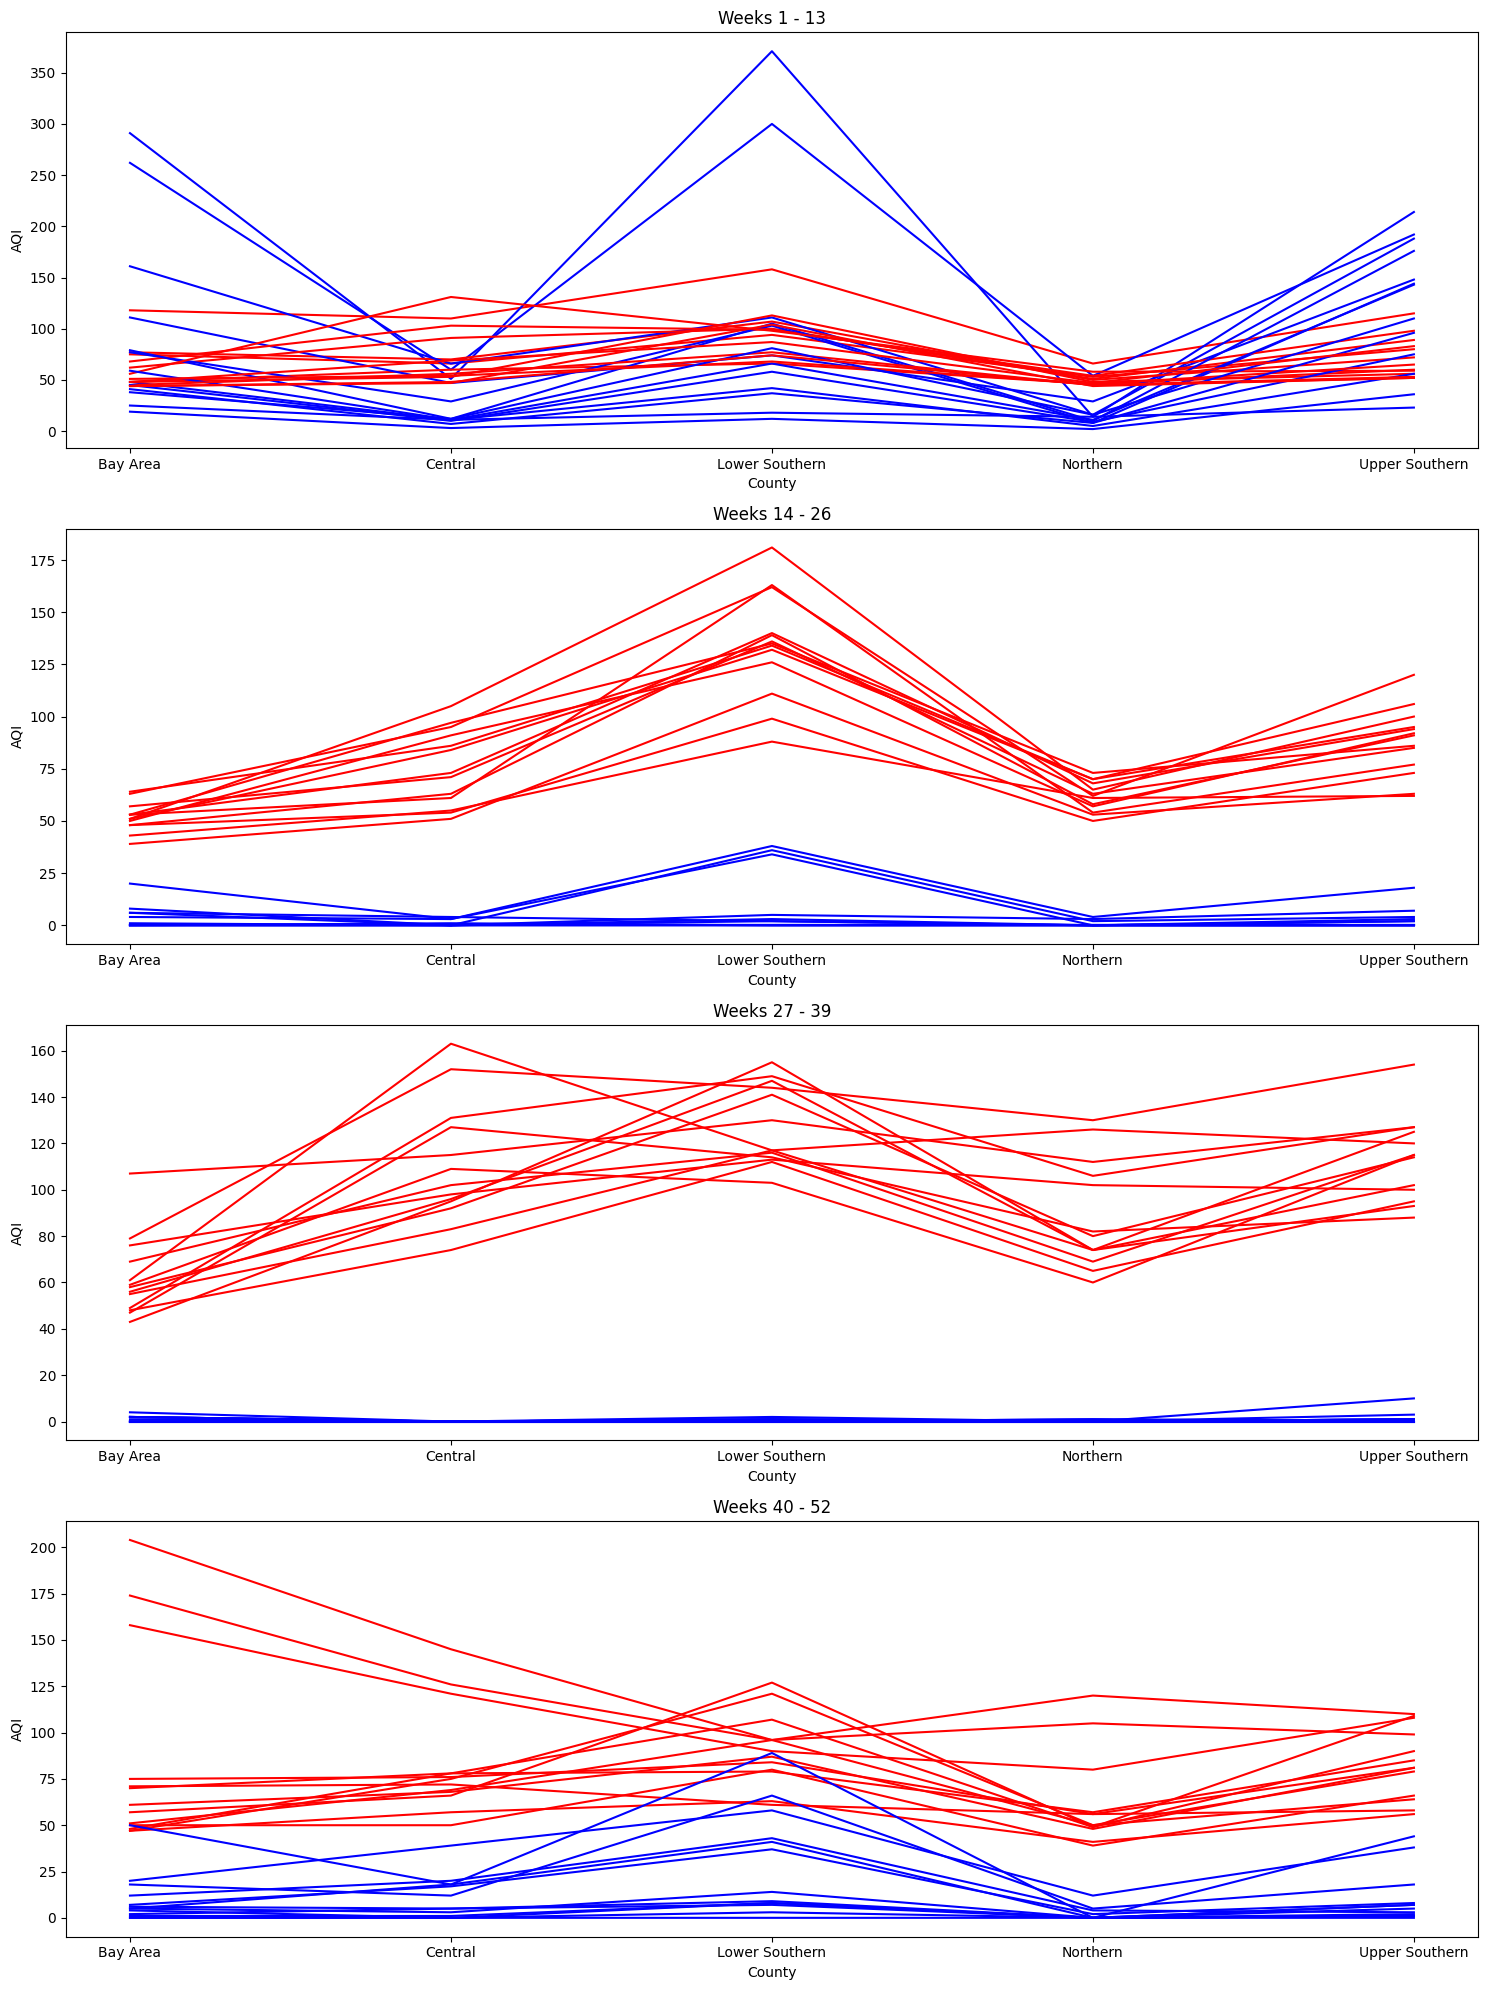

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
week_count = df_plot["DATE_CODE"].nunique()
weeks_per_subplot = 13
unique_regions = df_plot["REGION"].unique()

for i in range(4):
    start_week = i * weeks_per_subplot
    end_week = min(start_week + weeks_per_subplot, week_count)

    weeks = df_plot["DATE_CODE"].unique()[start_week:end_week]
    for week in weeks:
        week_row = df_plot.loc[df_plot["DATE_CODE"] == week]
        # Create a dictionary to store REGIONAL_MEAN_AQI values for each unique region in the current week
        regional_mean_aqi_dict = {}
        regional_cases_dict = {}
        for region in unique_regions:
            regional_mean_aqi = week_row.loc[
                week_row["REGION"] == region, "REGIONAL_MEAN_AQI"
            ].values
            regional_cases_count = week_row.loc[
                week_row["REGION"] == region, "INFLUENZA_POSTIVE_CASES"
            ].values
            if len(regional_mean_aqi) > 0:
                regional_mean_aqi_dict[region] = regional_mean_aqi[0]
                regional_cases_dict[region] = regional_cases_count[0]

        # Plot the data for the current week
        axs[i].plot(
            list(regional_mean_aqi_dict.keys()),
            list(regional_mean_aqi_dict.values()),
            label=f"Week {week}",
            color="Red",
        )
        axs[i].plot(
            list(regional_cases_dict.keys()),
            list(regional_cases_dict.values()),
            label=f"Week {week}",
            color="Blue",
        )
        axs[i].set_title(f"Weeks {start_week+1} - {end_week}")
        axs[i].set_xlabel("County")
        axs[i].set_ylabel("AQI")

plt.tight_layout()
plt.show()

##### Subtle Corelation found in some weeks

- In the last weeks of 2018 (40 - 52), we can see a subtle corelation between the number of influenza disease cases and the regional AQI.
- The relation can be seen in the Lower Southern & Upper Southern Region of California


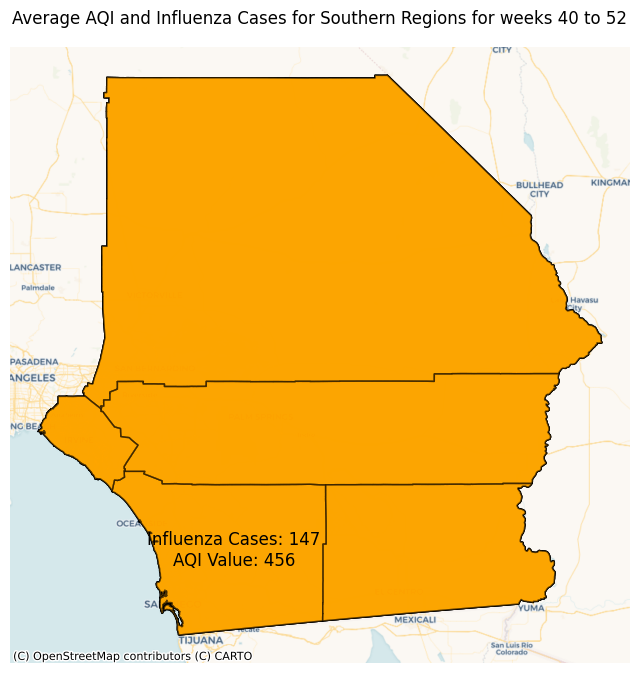

In [ ]:
corelation_df = new_final_data_2018.loc[
    (new_final_data_2018["REGION"] == "Lower Southern")
    & (new_final_data_2018["DATE_CODE"] >= 201840)
]

# Taking the average Influenza Cases for weeks 40-52
max_cases_week = corelation_df.groupby("DATE_CODE")["INFLUENZA_POSTIVE_CASES"].sum()
avg_cases = max_cases_week.sum() / max_cases_week.count()

# Taking the average AQI for weeks 40-52
max_aqi_week = corelation_df.groupby("DATE_CODE")["REGIONAL_MEAN_AQI"].sum()
avg_aqi = max_aqi_week.sum() / max_aqi_week.count()

fig, axs = plt.subplots(figsize=(8, 8))

corelation_df.plot(
    column="REGION",
    color="orange",
    alpha=0.3,
    legend=True,
    ax=axs,
    edgecolor="black",
    linewidth=1,
)

for region in corelation_df["REGION"].unique():
    row = week_row.loc[week_row["REGION"] == region].iloc[0]
    annotation_text = f"Influenza Cases: {int(avg_cases)}\nAQI Value: {int(avg_aqi)}"
    centroid = row.geometry.centroid
    axs.annotate(
        annotation_text,
        xy=(centroid.x, centroid.y),
        xytext=(
            centroid.x + 0.1,
            centroid.y - (0.1 if region != "Northern" else -0.5),
        ),
        ha="center",
        va="center",
        color="black",
        fontsize=12,
    )
axs.set_axis_off()
axs.set_title("Average AQI and Influenza Cases for Southern Regions for weeks 40 to 52")

cx.add_basemap(
    axs, crs=corelation_df.crs.to_string(), source=cx.providers.CartoDB.Voyager
)

### Results

As we can see from these results, there is no corelation between the data of Influenza Cases and AQI data. The reasons can the following:

- The influenza cases does not represent the level of illness caused by poor air quality.
- The influenza cases data was high resolution and was available region wise whereas the AQI data was available county wise. AQI is different for every county and a cluster of counties does not correctly respresent its overall air quality.
